<a href="https://colab.research.google.com/github/HenriqueCR1291/sentiment_analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install google-play-scraper

     |████████████████████████████████| 52 kB 787 kB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.2-py3-none-any.whl size=24393 sha256=067b4be3202c943eb111cc3ebb45e30b6f245d907ec5a8e7631c0cc5055548ad
  Stored in directory: /root/.cache/pip/wheels/98/99/eb/bbb9d24a5c526980647efc10336eaaeffcf07749f581111128
Successfully built google-play-scraper


In [10]:
import json
import torch

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import torch.nn.functional as F

#from ktrain                  import text
from tqdm                    import tqdm
from matplotlib              import rc
from pygments                import highlight
from pygments.lexers         import JsonLexer
from pygments.formatters     import TerminalFormatter
from transformers            import pipeline
from google_play_scraper     import Sort, reviews, app
from sklearn.model_selection import train_test_split
from pylab                   import rcParams
from collections             import defaultdict
from textwrap                import wrap
from torch                   import nn, optim
from torch.utils.data        import Dataset, DataLoader
from sklearn.metrics         import confusion_matrix, classification_report
from transformers            import AutoTokenizer, AutoModelForSequenceClassification,BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [11]:
app_ep = 'com.thomsonreuters.reuters'
app_infos = []

info = app(app_ep, lang='en', country='us')
del info['comments']
app_infos.append(info)

In [19]:
def print_json(json_object):
    json_str = json.dumps(json_object, indent=2, sort_keys=True, default=str)
    return json_str

In [13]:
json_str = print_json(app_infos[0])
print(highlight(json_str, JsonLexer(), TerminalFormatter()))

{
  "adSupported": true,
  "androidVersion": "7.0",
  "androidVersionText": "7.0 and up",
  "appId": "com.thomsonreuters.reuters",
  "containsAds": true,
  "contentRating": "Everyone 10+",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Your world, your news. Catch up on what\u2019s happening in the world 24/7 with Reuters News.\r\n\r\n\u2022 The resources of the world\u2019s largest and most trusted news organization at your fingertips \u2014 2,500 reporters in 200 locations.\r\n\u2022 Global news coverage of the world.\r\n\u2022 Alerts for breaking news and the stories you care about the most. \r\n\u2022 Catch up quickly and on the go with new Editorial Highlights.\r\n\u2022 Your personal Market Watchlist, plus stocks, bonds, currencies and commodities analysis.\r\n\u2022 Constantly updated with new features: Save stories to read later, Night Mode, Editorial Highlights, Offline Access, and more.\r\n\r\nDo Not Sell: https://privacyportal-cdn.onetrust.com/dsa

In [15]:
app_reviews = []

for i in tqdm(app_ep):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        i,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = i
      app_reviews.extend(rvs)

100%|██████████| 26/26 [00:16<00:00,  1.53it/s]


In [141]:
json_str = print_json(app_reviews[0])
print(highlight(json_str, JsonLexer(), TerminalFormatter()))

IndexError: ignored

In [22]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

**Data Analysis**

In [95]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 48.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 62.5MB/s]


In [96]:
df = pd.read_csv('reviews.csv')

In [97]:
df.dtypes

userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
sortOrder               object
appId                   object
dtype: object

In [142]:
df.shape

(15746, 12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


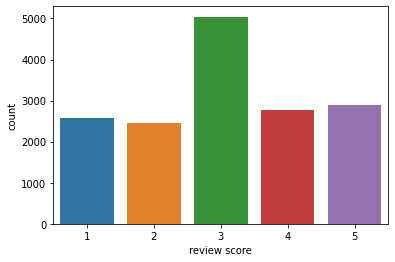

In [98]:
sns.countplot(df.score)
plt.xlabel('review score');

In [99]:
df['sentiment'] = 0
df['sentiment'] = df.apply(lambda x: 'negative' if x['score'] <= 2 else ''
                                            'neutral' if x['score'] == 3 else ''
                                            'positive' if x['score'] >= 4 else '', axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review sentiment')

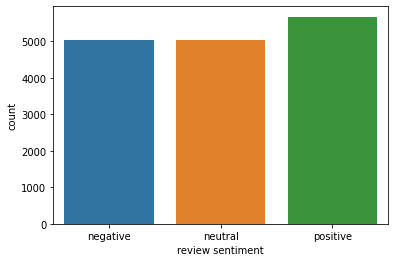

In [100]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')

Data Preprocessing

In [101]:
trained_model = 'bert-base-cased'

In [102]:
tokenizer = BertTokenizer.from_pretrained(trained_model)

In [103]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


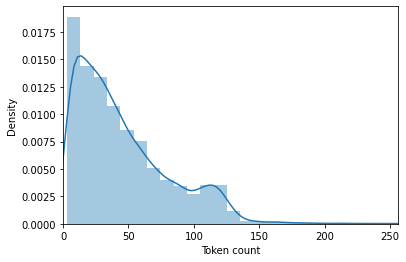

In [104]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [119]:
MAX_LEN = 160

In [123]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [137]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [138]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [126]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [149]:
BATCH_SIZE = 7873

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [150]:
train_data_loader

In [152]:
data = next(iter(val_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


TypeError: ignored

In [91]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

NameError: ignored

**Classification with Hugging Face**

In [54]:
bert_model = BertModel.from_pretrained(trained_model)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
